# Atividade Aprendizagem de Máquina - Spark MLLib

Considerando o dataset detalhado a seguir, aplique as técnicas solicitadas

### Dataset dados de sensores veicular

- Arquivo disponível em /home/dados/sensores/treinamento.csv
- Arquivo disponível em /home/dados/sensores/teste.csv
- Dados relativos a sensores de internet das coisas (IoT) para detecção de estados dos medidores


| #  	| Nome do campo           	| Descrição                                                                     	|
|----	|-------------------------	|-------------------------------------------------------------------------------	|
| 0  	| Hora               	| Hora média das medições                                                          	|
| 1  	| Minuto         	| Minuto médio das medições                                               	|
| 2  	| Temp_minima         	| Temperatura mínima das medições                                               	|
| 3  	| Temp_maxima         	| Temperatura máxima das medições                                               	|
| 4  	| Latitude_media  	| Latitude média das medições                             	|
| 5  	| Longitude_media  	| Longitude média das medições                             	|
| 6  	| Classe  	| Estado do medidor (Frio, Moderado, Quente, Alerta)                             	|


**Informações a serem extraídas:**

1. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
2. Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe (falso-negativo) para os classificadores
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
3. Determine qual a quantidade de eventos não Alerta (label = 0.0, ou label = 1.0, ou label = 2.0) classificados erroneamente como classe Alerta (falso-positivo) para os classificadores
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
4. Faça votação entre os classificadores da etapa 1.A, 1.B e 1.C para atribuir a classe do evento de acordo com a maioria das classes entre os classificadores
    - Dicas: Para isto, voce irá precisar fazer o join das predições de cada classificador de acordo com os IDs dos eventos. Posteriormente voce pode manipular o dataframe, após o join, para determinar qual classe de cada evento possuiu maior votação =). Exemplo de código:
```python

    import pyspark.sql.functions as func
    
    predicaoDT.select(func.col('prediction').alias('prediction_dt'),
                        func.col('label'),
                        func.col('id'))\
    .join(predicaoRF.select(func.col('prediction').alias('prediction_rf'),
                        func.col('id')), ['id'])
```
5. Considerando que voce possui apenas duas classes: Não Alerta e Alerta. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 20 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=20 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
        - Dicas: Para isto, você irá precisar manipular o dataframe para alterar os valores da coluna label, por exemplo através de uma UDF
6. Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe (falso-negativo) para os classificadores do item 5
7. Faça busca de parametros dos classificadores desenvolvidos no item 5. Plote um gráfico relacionando a acurácia e os parametros otimizados
    1. Árvore de Decisão varie o parametro maxDepth de 1 a 20
    2. Random Forest varie o numTrees de 1 a 20

**Dicas:**
- *Crie uma célula (Insert -> Insert Cell Below) para cada informação solicitada*
- *A análise deve ser feita sobre os dados do HDFS*
- *Inicialize o seu cluster executando o script em: Desktop/ambientes/spark/inicializar.sh*
- *Acesse o seu cluster executando o script em: Desktop/ambientes/spark/abrir_navegador.sh*

In [1]:
import os
os.environ['PYSPARK_PYTHON']='/usr/bin/python3'

from pyspark.sql import SparkSession

sc = SparkSession\
    .builder\
    .master('spark://spark-master:7077')\
    .config('spark.executor.memory','1g')\
    .getOrCreate()

In [2]:
dfTreino = sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('hdfs://namenode:9000/treinamento.csv')

dfTeste = sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('hdfs://namenode:9000/teste.csv')

In [3]:
dfTreino.printSchema()

root
 |-- hora: double (nullable = true)
 |-- minuto: double (nullable = true)
 |-- temp_minima: double (nullable = true)
 |-- temp_maxima: double (nullable = true)
 |-- latitude_media: double (nullable = true)
 |-- longitude_media: double (nullable = true)
 |-- Classe: string (nullable = true)



In [4]:
from pyspark.sql.functions import monotonically_increasing_id

dfTeste = dfTeste.withColumn('id', monotonically_increasing_id())
dfTeste.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+
only showing top 5 rows



In [5]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

features = ['hora', 'minuto', 'temp_minima', 'temp_maxima', 'latitude_media', 'longitude_media']

# Criando Y (df treino)
dfTreino = StringIndexer(inputCol='Classe', outputCol='label')\
    .fit(dfTreino)\
    .transform(dfTreino)

# Criando X (df treino)
dfTreino = VectorAssembler(inputCols=features, outputCol='features')\
    .transform(dfTreino)

dfTreino.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|11.312758|30.169239|     -1.859|     27.495|     36.169994|      139.23022|Moderado|  0.0|[11.312758,30.169...|
|11.292323|29.638779|   8.542997|  36.177994|     31.349113|       73.50964|  Quente|  3.0|[11.292323,29.638...|
|11.600304| 29.64275|     -1.861|  27.695002|      36.17158|      139.22937|Moderado|  0.0|[11.600304,29.642...|
|11.462425|30.157314|   9.776998|  36.077995|     31.351593|        73.5104|  Quente|  3.0|[11.462425,30.157...|
|11.735474|  29.9684|     -1.662|  27.695002|     36.169456|      139.23021|Moderado|  0.0|[11.735474,29.968...|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+-----

In [6]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

features = ['hora', 'minuto', 'temp_minima', 'temp_maxima', 'latitude_media', 'longitude_media']

# Criando Y (df teste)
dfTeste = StringIndexer(inputCol='Classe', outputCol='label')\
    .fit(dfTeste)\
    .transform(dfTeste)

# Criando X (df teste)
dfTeste = VectorAssembler(inputCols=features, outputCol='features')\
    .transform(dfTeste)

In [7]:
#informação 1.A
from pyspark.ml.classification import DecisionTreeClassifier
import pyspark.sql.functions as func

dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
modeloDT = dt.fit(dfTreino)

In [8]:
predicaoDT = modeloDT.transform(dfTeste)
predicaoDT.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [9]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoDT)

0.9381280440070245

In [10]:
#informação 1.B - Random Forest com 5 arvores 
#                (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor 
#                 do RandomForestClassifier)


In [10]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5)

In [11]:
modeloRF = rf.fit(dfTreino)

In [12]:
predicaoRF = modeloRF.transform(dfTeste)

In [13]:
predicaoRF.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [14]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF)

0.9344879008090252

In [16]:
#informação 1.C - Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)


In [15]:
rf2 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
modeloRF2 = rf2.fit(dfTreino)

In [16]:
predicaoRF2 = modeloRF2.transform(dfTeste)
predicaoRF2.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [17]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF2)

0.9475615534121986

In [ ]:
# 2 - Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe 
#     (falso-negativo) para os classificadores

#informação 2.A - Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)


In [18]:
predicaoRF.select(func.col('label'), func.col('Classe')).distinct().show(5)

+-----+--------+
|label|  Classe|
+-----+--------+
|  3.0|  Quente|
|  2.0|    Frio|
|  0.0|Moderado|
|  1.0|  Alerta|
+-----+--------+



In [19]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

# Precisa de cast(FloatType()), e ordenar por previsão. Caso contrário não funciona
preds_and_labels = predicaoDT.select(['prediction','label'])\
                    .withColumn('label', func.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [20]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[167508.      0.   8325.   3537.]
 [     0. 157455.      0.   8586.]
 [  2988.      0. 153414.      0.]
 [  1665.  10683.      0.  64710.]]


In [ ]:
################
# Segundo modo #
################

In [21]:
predicaoDT.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction') != func.col('label')).count() / predicaoDT.filter(func.col('Classe') == 'Alerta').count()

0.0517101197896905

In [ ]:
#informação 2.B - Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, 
#                 e numTrees=5 no construtor do RandomForestClassifier)


In [22]:
# Precisa de cast(FloatType()), e ordenar por previsão. Caso contrário não funciona
preds_and_labels = predicaoRF.select(['prediction','label'])\
                    .withColumn('label', func.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels.show(5)


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [23]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[167931.      0.   8685.   2754.]
 [     0. 154656.      0.  11385.]
 [  2556.      0. 153846.      0.]
 [  1143.  11475.      0.  64440.]]


In [24]:
################
# Segundo modo #
################
predicaoRF.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction') != func.col('label')).count() / predicaoRF.filter(func.col('Classe') == 'Alerta').count()

0.06856740202721015

In [ ]:
#informação 2.C - Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)


In [25]:
preds_and_labels = predicaoRF2.select(['prediction','label'])\
                    .withColumn('label', func.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [26]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[170433.      0.   6084.   2853.]
 [     0. 162072.      0.   3969.]
 [  2619.      0. 153783.      0.]
 [  1269.  13194.      0.  62595.]]


In [27]:
################
# Segundo modo #
################
predicaoRF2.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction') != func.col('label')).count() / predicaoRF2.filter(func.col('Classe') == 'Alerta').count()

0.023903734619762588

In [ ]:
# 3 - Determine qual a quantidade de eventos não Alerta (label = 0.0, ou label = 1.0, ou label = 2.0) 
#     classificados erroneamente como classe Alerta (falso-positivo) para os classificadores


#informação 3.A - Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)


In [28]:
predicaoDT.printSchema()

root
 |-- hora: double (nullable = true)
 |-- minuto: double (nullable = true)
 |-- temp_minima: double (nullable = true)
 |-- temp_maxima: double (nullable = true)
 |-- latitude_media: double (nullable = true)
 |-- longitude_media: double (nullable = true)
 |-- Classe: string (nullable = true)
 |-- id: long (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [29]:
predicaoDT.filter(func.col('Classe') != 'Alerta')\
    .filter(func.col('prediction') == 1).count() / predicaoDT.filter(func.col('Classe') != 'Alerta').count()

0.025877479834314366

In [ ]:
#informação 3.B - Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, 
#                 e numTrees=5 no construtor do RandomForestClassifier)


In [30]:
predicaoRF.filter(func.col('Classe') != 'Alerta')\
    .filter(func.col('prediction') == 1).count() / predicaoRF.filter(func.col('Classe') != 'Alerta').count()

0.02779594506213211

In [ ]:
#informação 3.C - Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)


In [31]:
predicaoRF2.filter(func.col('Classe') != 'Alerta')\
    .filter(func.col('prediction') == 1).count() / predicaoRF2.filter(func.col('Classe') != 'Alerta').count()

0.03195988663614563

In [32]:
#informação 4 - Faça votação entre os classificadores da etapa 1.A, 1.B e 1.C para atribuir a classe do evento de 
#               acordo com a maioria das classes entre os classificadores

import pyspark.sql.functions as func


In [33]:
print(f'Tamanho predicaoDT:', predicaoDT.count())
print(f'Tamanho predicaoRF:', predicaoRF.count())
print(f'Tamanho predicaoRF2:', predicaoRF2.count())

Tamanho predicaoDT: 578871
Tamanho predicaoRF: 578871
Tamanho predicaoRF2: 578871


In [34]:
predicaoDT.select(func.col('prediction').alias('prediction_dt'),
                  func.col('label'),
                  func.col('id'))\
.join(predicaoRF.select(func.col('prediction').alias('prediction_rf'),
                  func.col('id')), ['id'])\
.join(predicaoRF2.select(func.col('prediction').alias('prediction_rf2'),
                  func.col('id')), ['id']).count()

578871

In [35]:
df = predicaoDT.select(func.col('prediction').alias('prediction_dt'),
                  func.col('label'),
                  func.col('id'))\
.join(predicaoRF.select(func.col('prediction').alias('prediction_rf'),
                  func.col('id')), ['id'])\
.join(predicaoRF2.select(func.col('prediction').alias('prediction_rf2'),
                  func.col('id')), ['id'])

In [36]:
df.show(5)

+----+-------------+-----+-------------+--------------+
|  id|prediction_dt|label|prediction_rf|prediction_rf2|
+----+-------------+-----+-------------+--------------+
|  26|          0.0|  0.0|          0.0|           0.0|
|  29|          1.0|  1.0|          1.0|           1.0|
| 474|          1.0|  1.0|          1.0|           1.0|
| 964|          2.0|  0.0|          2.0|           2.0|
|1677|          0.0|  0.0|          0.0|           0.0|
+----+-------------+-----+-------------+--------------+
only showing top 5 rows



In [37]:
from statistics import mode
from pyspark.sql.functions import udf, array
from pyspark.sql.types import DoubleType


In [38]:
def retornaMaior(x, y, z):
    lista = [x, y, z]
    try:
        return mode(lista)
    except:
        return z

udfModa = udf(lambda x, y, z: retornaMaior(x, y, z), DoubleType())

In [39]:
udfVota = udf(lambda x: mode(x))

listaPreds = df.withColumn('lista_preds', udfModa(func.col('prediction_dt'), 
                                                  func.col('prediction_rf'), 
                                                  func.col('prediction_rf2')))

listaPreds.show(5)


+----+-------------+-----+-------------+--------------+-----------+
|  id|prediction_dt|label|prediction_rf|prediction_rf2|lista_preds|
+----+-------------+-----+-------------+--------------+-----------+
|  26|          0.0|  0.0|          0.0|           0.0|        0.0|
|  29|          1.0|  1.0|          1.0|           1.0|        1.0|
| 474|          1.0|  1.0|          1.0|           1.0|        1.0|
| 964|          2.0|  0.0|          2.0|           2.0|        2.0|
|1677|          0.0|  0.0|          0.0|           0.0|        0.0|
+----+-------------+-----+-------------+--------------+-----------+
only showing top 5 rows



In [87]:
#5 - Considerando que voce possui apenas duas classes: Não Alerta e Alerta. Calcule a acurácia de classificação 
#    na base de testes para os seguintes classificadores:

#informação 5.A - Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
from pyspark.sql.types import StringType
dfTeste5 = dfTeste

In [88]:
dfTeste5.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|  0.0|[11.787212,29.005...|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|  0.0|[11.482636,29.845...|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|  0.0|[11.312064,29.751...|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|  0.0|[11.530982,29.505...|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|  0.0|[11.4008,29.42228...|
+---------+---------+-----------+-----------+--------------+----

In [89]:
def mudaLabel(x):
    try:
        if x == 1.0:
            return x
        else:
            return 0.0
    except:
        pass

    
udfMudaLabel = udf(lambda x: mudaLabel(x), DoubleType())

In [90]:
dfTeste5 = dfTeste5.withColumn('label', udfMudaLabel(func.col('label')))

In [91]:
dfTeste5.show(50)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|  0.0|[11.787212,29.005...|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|  0.0|[11.482636,29.845...|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|  0.0|[11.312064,29.751...|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|  0.0|[11.530982,29.505...|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|  0.0|[11.4008,29.42228...|
| 11.50784| 29.18513|      1.423|  29.106003|     34.559834|    

In [92]:
dfTreino5 = dfTreino

In [95]:
dfTreino5 = dfTreino5.withColumn('label', udfMudaLabel(func.col('label')))

In [96]:
dt5 = DecisionTreeClassifier(labelCol='label', featuresCol='features')
modeloDT5 = dt.fit(dfTreino5)

In [97]:
predicaoDT5 = modeloDT5.transform(dfTeste5)
predicaoDT5.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [100]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoDT5)

0.9687772256172641

In [ ]:
#informação 5.B - Random Forest com 20 arvores (from pyspark.ml.classification import RandomForestClassifier, 
#                 e numTrees=20 no construtor do RandomForestClassifier)
    


In [105]:
rf5 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)



In [106]:
modeloRF5 = rf.fit(dfTreino5)



In [107]:
predicaoRF5 = modeloRF5.transform(dfTeste5)



In [108]:
predicaoRF5.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)



+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [109]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF5)

0.967854887708866

In [ ]:
#informação 5.C - Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
# Dicas: Para isto, você irá precisar manipular o dataframe para alterar os valores da coluna label, por exemplo
# através de uma UDF




In [110]:
rf5100 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)


In [111]:
modeloRF5100 = rf.fit(dfTreino5)

In [112]:
predicaoRF5100 = modeloRF5100.transform(dfTeste5)

In [113]:
predicaoRF5100.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [114]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF5100)

0.967854887708866

In [ ]:
#informação 6 - Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra
# classe (falso-negativo) para os classificadores do item 5


In [115]:
preds_and_labels = predicaoDT5.select(['prediction','label'])\
                    .withColumn('label', func.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [116]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[395964.  16866.]
 [  1440. 164601.]]


In [121]:
################
# Segundo modo #
################
predicaoDT5.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction') != func.col('label')).count() / predicaoDT5.filter(func.col('Classe') == 'Alerta').count()

0.008672556778145157

In [117]:
preds_and_labels = predicaoRF5.select(['prediction','label'])\
                    .withColumn('label', func.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [118]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[395721.  17109.]
 [  1737. 164304.]]


In [122]:
################
# Segundo modo #
################
predicaoRF5.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction') != func.col('label')).count() / predicaoRF5.filter(func.col('Classe') == 'Alerta').count()

0.010461271613637595

In [119]:
preds_and_labels = predicaoRF5100.select(['prediction','label'])\
                    .withColumn('label', func.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [120]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[395721.  17109.]
 [  1737. 164304.]]


In [123]:
################
# Segundo modo #
################
predicaoRF5100.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction') != func.col('label')).count() / predicaoRF5100.filter(func.col('Classe') == 'Alerta').count()

0.010461271613637595

In [ ]:
#Faça busca de parametros dos classificadores desenvolvidos no item 5. Plote um gráfico relacionando a 
#acurácia e os parametros otimizados
#informação 7.A - Árvore de Decisão varie o parametro maxDepth de 1 a 20


In [159]:
scores = []

In [160]:
for i in range(1, 21):
    dt7 = DecisionTreeClassifier(labelCol='label', featuresCol='features', maxDepth=i)
    modeloDT7 = dt7.fit(dfTreino5)
    print(modeloDT7)
    predict = modeloDT7.transform(dfTeste5)
    scores.append(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
        .evaluate(predict))

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_660e2a982193) of depth 1 with 3 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_53257aaa6486) of depth 2 with 7 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_652470632520) of depth 3 with 11 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_9ac62dc11cc7) of depth 4 with 23 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_46cafbc081e8) of depth 5 with 31 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_d31a24ecc0e5) of depth 6 with 63 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_550c43281a73) of depth 7 with 97 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_3b1c4fa096d2) of depth 8 with 145 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_f9df6f90b978) of depth 9 with 245 nodes
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_b711df54e100) of depth 10 with 307 nodes
Decision

In [161]:
print(scores)

[0.931824021241347, 0.9421565448575537, 0.9448972528461714, 0.9619368309301344, 0.9687772256172641, 0.977220077171886, 0.9774981976035102, 0.9826598313262809, 0.9839005463703259, 0.9842370490567578, 0.9866071295270119, 0.9868043295336977, 0.9861691597318394, 0.9858732164058155, 0.9861859575259742, 0.9862916055026221, 0.9864619906161198, 0.9865233516403251, 0.9865229100139867, 0.9866635184173203]


In [162]:
import matplotlib.pyplot as plt

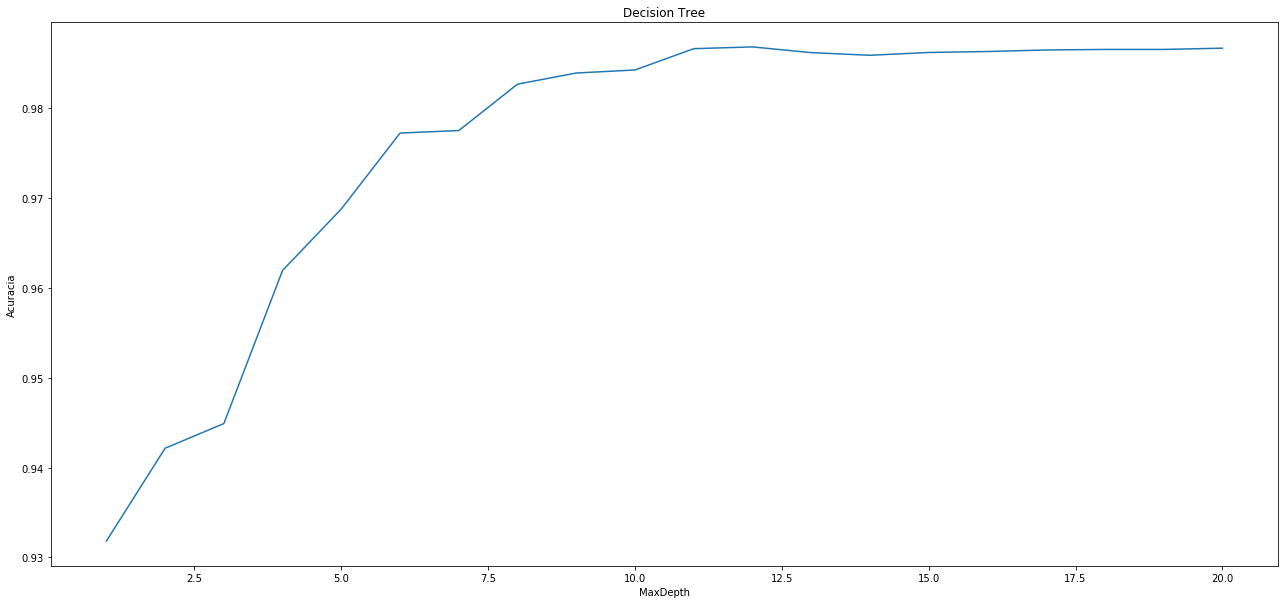

In [164]:
fig = plt.figure(figsize=(22,10))
plt.title('Decision Tree')
plt.xlabel('MaxDepth')
plt.ylabel('Acuracia')
plt.plot(range(1,21),scores)
plt.show()

In [ ]:
#informação 7.B - Random Forest varie o numTrees de 1 a 20


In [165]:
scoresRF = []

In [166]:
for i in range(1, 21):
    rf7 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=i)
    modeloRF7 = rf7.fit(dfTreino5)
    print(modeloRF7)
    predict = modeloRF7.transform(dfTeste5)
    scoresRF.append(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
        .evaluate(predict))

RandomForestClassificationModel (uid=RandomForestClassifier_f1020bb51aa1) with 1 trees
RandomForestClassificationModel (uid=RandomForestClassifier_1ec630c87b72) with 2 trees
RandomForestClassificationModel (uid=RandomForestClassifier_897b08a06ad9) with 3 trees
RandomForestClassificationModel (uid=RandomForestClassifier_71319bff1e09) with 4 trees
RandomForestClassificationModel (uid=RandomForestClassifier_0640ab086da4) with 5 trees
RandomForestClassificationModel (uid=RandomForestClassifier_69c25f139a02) with 6 trees
RandomForestClassificationModel (uid=RandomForestClassifier_5f0f6b0ebcd4) with 7 trees
RandomForestClassificationModel (uid=RandomForestClassifier_03b619b6c19a) with 8 trees
RandomForestClassificationModel (uid=RandomForestClassifier_bce50e386e4f) with 9 trees
RandomForestClassificationModel (uid=RandomForestClassifier_92ecfff24114) with 10 trees
RandomForestClassificationModel (uid=RandomForestClassifier_8452333cf81d) with 11 trees
RandomForestClassificationModel (uid=Rand

In [167]:
print(scoresRF)

[0.9693706653059002, 0.9714527146879491, 0.968456086488395, 0.9675674072582638, 0.967854887708866, 0.9722657859804615, 0.975630265291107, 0.9757649230292155, 0.9715880912491546, 0.974474877170286, 0.9719600477792781, 0.9729963379595874, 0.9730262194671968, 0.9741780013674535, 0.9733458724720345, 0.9732590082335517, 0.9727920024056073, 0.9730201904339078, 0.9699418797632948, 0.9752947340024619]


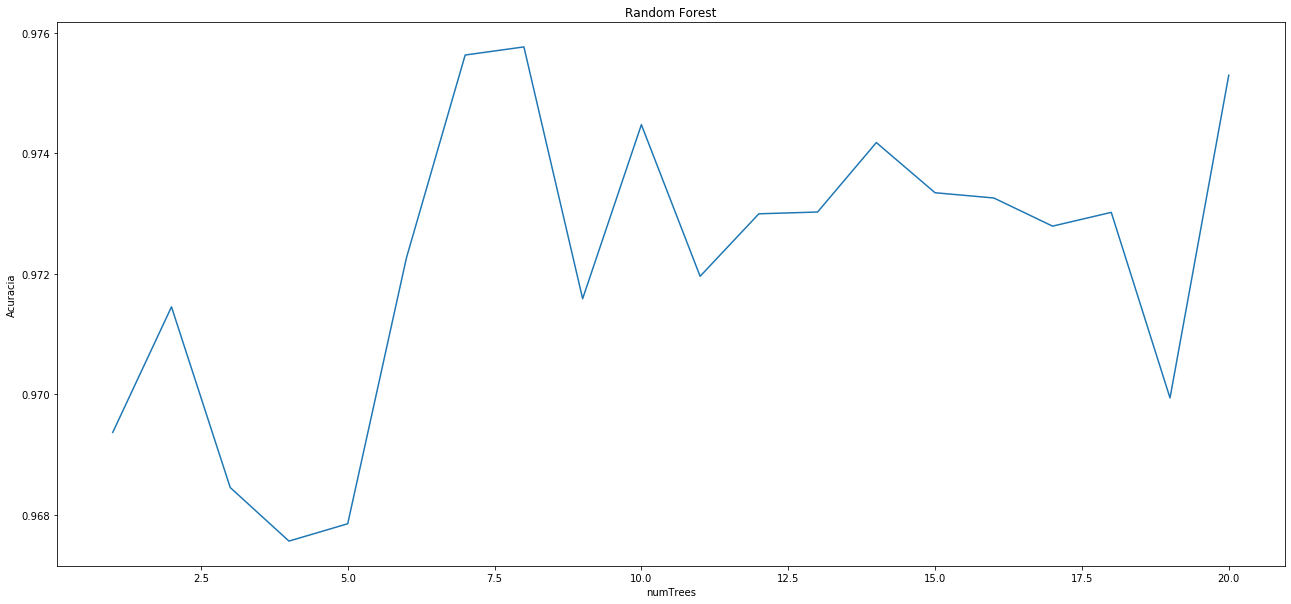

In [168]:
fig = plt.figure(figsize=(22,10))
plt.title('Random Forest')
plt.xlabel('numTrees')
plt.ylabel('Acuracia')
plt.plot(range(1,21),scoresRF)
plt.show()